In [ ]:
!pip install librosa==0.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 5.4 MB/s 
  Attempting uninstall: librosa
    Found existing installation: librosa 0.8.1
    Uninstalling librosa-0.8.1:
      Successfully uninstalled librosa-0.8.1


In [ ]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pesq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pesq: filename=pesq-0.0.4-cp37-cp37m-linux_x86_64.whl size=214588 sha256=e82cc0fcac6398b32a80d9732ad30c7ec88b9ab578a8a023f47bb0c0126eb615
  Stored in directory: /root/.cache/pip/wheels/c5/3d/9c/542731f8357f7c82eb6ac2047cc5375f92c9a05b09a715aff6
Successfully built pesq


In [ ]:
pip install memspectrum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
import numpy as np
from pydub import AudioSegment
import os
from scipy.io.wavfile import write

from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy import interpolate

from math import cos

from memspectrum import MESA


In [ ]:
def get_channels(path):
   sound = AudioSegment.from_file(path, format="mp3")
   return sound.split_to_mono()

def get_sample(sound, chunk_size, loss_percentage=0.25): 
  peak_amplitude = sound.max
  loudness = sound.dBFS
  channels_cnt = sound.channels
  raw = np.array(sound.get_array_of_samples())

  frame_r = sound.frame_rate
  audio_info = np.array([peak_amplitude, channels_cnt, sound.frame_rate, 
              chunk_size, sound.frame_count()/ sound.frame_rate], dtype=object)
  
  cur_loss = 0

  package = []
  size = chunk_size * channels_cnt
  cnt = 0

  while (cnt + 1) * size < len(raw):
    cur_loss += loss_percentage
    if abs(cur_loss - 1) < 10**(-15):
      chunk = np.array([-32768 for _ in range(size)], dtype="int16")
      cur_loss = 0
    else :
      chunk = np.array(raw[(cnt * size) : ((cnt + 1)*size)], dtype='int16')


    package.append(chunk)
    cnt += 1

  package = np.array(package)
  audio = np.array([package, audio_info])
  return audio

In [ ]:
def is_broken(chunk):
  return np.array_equal(chunk, np.array([-32768 for _ in range(chunk.shape[0])], dtype="int16"))

In [ ]:
def get_audio(audio_array, broken_audio_path):
  cp_audio_array = deepcopy(audio_array)
  broken_chunk = np.array([-32768 for _ in range(cp_audio_array[1][3] * cp_audio_array[1][1])], dtype="int16")
  for i in range(len(cp_audio_array[0])):
    if np.array_equal(cp_audio_array[0][i], broken_chunk):
      cp_audio_array[0][i] = np.zeros(cp_audio_array[1][3] * cp_audio_array[1][1], dtype="int16")
  song = AudioSegment(cp_audio_array[0].tobytes(), frame_rate=cp_audio_array[1][2], sample_width=2, channels=cp_audio_array[1][1])
  song.export(broken_audio_path, format=broken_audio_path.split(".")[-1], bitrate="320k")

In [ ]:
def get_file_names(audio_path, num_samples, loss_percentage):
  paths = []

  path = audio_path.split("/")
  file_name = path.pop()

  path = "/".join(path) + "/"

  if loss_percentage < 10**(-15):
    paths.append(path + "{:.2f}".format(loss_percentage) + "___all_channels___" + file_name)

  for idx in range(1, num_samples + 1):
    paths.append(path + "{:.2f}".format(loss_percentage) + "___channel_" + str(idx) + "___" + file_name)

  return paths

def get_channel_samples(audio_path, chunk_size, loss_percentage, return_file_names = True):
  all_channels_sound = AudioSegment.from_file(audio_path, format="mp3")
  channels = get_channels(audio_path)

  channel_samples = []
  if loss_percentage < 10**(-15):
    channel_samples.append(get_sample(all_channels_sound, chunk_size, loss_percentage))
    file_names = get_file_names(audio_path, len(channels), loss_percentage)
  else:
    file_names = get_file_names(audio_path, len(channels), loss_percentage)

  for channel in channels:
    channel_samples.append(get_sample(channel, chunk_size, loss_percentage))

  for idx, sample in enumerate(channel_samples):
    get_audio(channel_samples[idx], file_names[idx])
  
  if return_file_names:
    return channel_samples, file_names
  return channel_samples


In [ ]:
def plot_channels(num_channels, channel_samples, title):
  fig, ax = plt.subplots(1, num_channels)

  plots_y = []

  size_y = channel_samples[0][0].shape[0]*channel_samples[0][0].shape[1]
  for i in range(num_channels):
    plots_y.append(channel_samples[i][0].copy())
    plots_y[i].resize(size_y)

  time = np.array(range(plots_y[0].shape[0])) / channel_samples[0][1][2]

  if num_channels == 1:
    plt.plot(time, plots_y[0])
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

  else:
    for idx, x in enumerate(ax):
      x.plot(time, plots_y[idx])
      x.set_xlabel("Time")
      x.set_ylabel("Amplitude")
      x.set_title(f"Channel {str(idx + 1)} {title}")

  plt.tight_layout()

In [ ]:
def  burg_AR(m,  x):
    """
    Based on Collomb's C++ code, pp. 10-11
    Burgs Method, algorithm and recursion
      m - number of lags in autoregressive model.
      x  - data vector to approximate.
    """
    N = len(x)-1
    coeffs = np.zeros(m)
    
    # initialize Ak
    Ak    = np.zeros(m+1)
    Ak[0] = 1.0 
    # initialize f and b.
    f  = x.copy()
    b = x.copy()
    # Initialize Dk
    Dk = 0.0
    for j in range(N+1):
        Dk += 2.0 * f[j] ** 2 
    Dk -= (f[0] ** 2) + (b[ N ] ** 2) 

    #Burg recursion
    for k in range(m):
        # compute mu
        mu = 0.0
        for n in range(N-k):
            mu += f[ n + k + 1 ] * b[ n ]
        try:
          mu *= -2.0 / Dk
        except:
          mu = 0
        # update Ak
        maxn = int((k+1)/2) + 1 # rounds down 
        # print("test")
        # print(maxn)
        for n in range(maxn):
            t1 = Ak[ n ] + mu * Ak[ k + 1 - n ]
            t2 = Ak[ k + 1 - n ] + mu * Ak[ n ]
            Ak[ n ] = t1
            Ak[ k + 1 - n ] = t2
        #update f and b
        for n in range(N-k):
            t1 = f[ n + k + 1 ] + mu * b[n]
            t2 = b[ n ] + mu * f[ n + k + 1]
            f[ n + k + 1 ] = t1
            b[ n ] = t2
            
        #update Dk
        Dk = ( 1.0 - mu ** 2) * Dk - (f[ k + 1 ] ** 2) - (b[ N - k - 1 ] ** 2)
    
    # assign coefficients.
    coeffs[:] = Ak[1:]
    
    return coeffs

########### OR ###########

#coeffs, _, _ = spectrum.arburg(func, order)



In [ ]:
def translate(value, leftMin, leftMax, rightMin, rightMax):
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    if leftSpan == 0:
      return 0
    
    valueScaled = float(value - leftMin) / float(leftSpan)

    return rightMin + (valueScaled * rightSpan)

In [ ]:
def Burg_method_extrapolation_with_lib(original_part, loss_percentage, 
                                       num_of_simulations = 1, speed = "Fast"):
  data = np.copy(original_part)

  min_data = np.min(data)
  max_data = np.max(data)

  data = [translate(i, min_data, max_data, -1, 1) for i in data]

  m = MESA()
  m.solve(data, method = speed)
  forecast = m.forecast(data, 
                        length = int(loss_percentage * original_part.shape[0] / (1 - loss_percentage)), 
                        number_of_simulations = num_of_simulations, include_data = False)
  median = np.median(forecast, axis = 0)

  median = [translate(i, -1, 1, min_data, max_data) for i in median]

  return median

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[3398, 3298, 3198, 3098, 2998, 2898, 2798, 2698, 2598, 2498, 2398, 2298, 2198, 2098, 1998, 1898, 1798, 1698, 1598, 1498, 1398, 1298, 1198, 1098, 998, 898, 798, 698, 598, 498, 398, 298, 198, 98]


In [ ]:
def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

a = [4231, 4543, 4718, 4726, 4570]
b = a.copy()

for idx, v in enumerate(b):
  b[idx] = translate(v, -5149, 4726, -1, 1)

print(a, b)

[4231, 4543, 4718, 4726, 4570] [0.899746835443038, 0.9629367088607594, 0.998379746835443, 1.0, 0.9684050632911392]


In [ ]:
def Burg_method_extrapolation(original_sound, lossy_sound):
  ####
  return 0

def extrapolate(original_sound, lossy_sound, loss_percentage, method = True):
  sample_nums = np.arange(0, N)
  ###
  plt.plot(original_sound, data[:], color = 'k')
  ###
  broken_chunks = []
  
  for idx, chunk in enumerate(lossy_sound):
    if is_broken(chunk):
      broken_chunks.append(idx)
  
  for chunk_idx in broken_chunks:



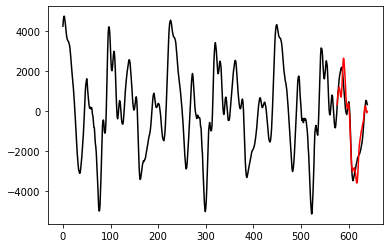

In [ ]:
def Burg_method_extrapolation_without_lib(original_part, loss_percentage):

  ranges = [[-1, 1], [0, 1], [-1, 0]]

  for new_range in ranges:
    data = np.copy(original_part)

    min_data = np.min(data)
    max_data = np.max(data)

    data = [translate(i, min_data, max_data, new_range[0], new_range[1]) for i in data]

    coeffs = burg_AR(original_part.shape[0] - 1, data)

    extrapolated = [0 for _ in range(int(loss_percentage * original_part.shape[0] / (1 - loss_percentage)))]

    data = data + extrapolated

    m = len(coeffs)
    for i in range(m + 1,  len(data)):
        for j in range(m):
            data[ i ] -= coeffs[ j ] * data[i - 1 - j]


    extrapolated = data[-int(loss_percentage * original_part.shape[0] / (1 - loss_percentage)):]
    extrapolated = [translate(i, new_range[0], new_range[1], min_data, max_data) for i in extrapolated]

    min_extrapolated = np.min(extrapolated)
    max_extrapolated = np.max(extrapolated)

    if (min_extrapolated < 2 * min_data or max_extrapolated > 2 * max_data):
      continue

    return extrapolated


dataaaaaaaaaaa
[4.231, 4.543, 4.718, 4.726, 4.57, 4.38, 4.12, 3.891, 3.693, 3.587, 3.523, 3.47, 3.448, 3.362, 3.262, 3.097, 2.842, 2.531, 2.211, 1.925, 1.672, 1.39, 1.127, 0.8, 0.426, 0.041, -0.385, -0.82, -1.296, -1.714, -2.112, -2.433, -2.714, -2.937, -3.043, -3.124, -3.107, -2.954, -2.738, -2.473, -2.193, -1.847, -1.446, -1.13, -0.637, -0.127, 0.374, 0.976, 1.293, 1.469, 1.602, 1.401, 1.022, 0.745, 0.475, 0.274, 0.128, 0.145, 0.182, 0.083, 0.166, 0.088, -0.179, -0.249, -0.531, -0.827, -0.84, -1.202, -1.6, -1.79, -2.08, -2.565, -3.155, -3.617, -4.223, -4.781, -5.005, -4.979, -4.632, -4.01, -3.266, -2.38, -1.408, -0.765, -0.548, -0.455, -0.648, -1.023, -1.116, -1.068, -0.727, -0.01, 1.032, 2.156, 3.07, 3.841, 4.188, 4.193, 4.014, 3.595, 3.017, 2.427, 2.058, 2.004, 2.159, 2.456, 2.778, 2.974, 2.913, 2.572, 2.06, 1.34, 0.662, 0.079, -0.332, -0.396, -0.22, 0.078, 0.353, 0.508, 0.448, 0.224, -0.113, -0.417, -0.592, -0.659, -0.661, -0.487, -0.168, 0.161, 0.58, 0.969, 1.283, 1.538, 1.78, 1.

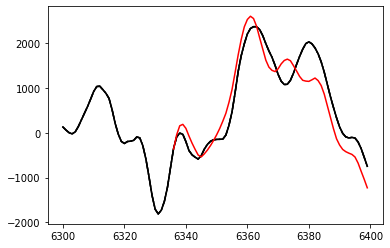

In [ ]:
def extrapolate(original_sound, lossy_sound, loss_percentage, method, num_of_simulations = 1, speed = "Fast"):

  chunk_size = original_sound.shape[1]
  one_extrapolation_block_size = chunk_size / loss_percentage

  original_sound_1d = np.copy(original_sound)
  original_sound_1d.resize(original_sound_1d.shape[0]*original_sound_1d.shape[1])

  broken_chunks = []
  
  for idx, chunk in enumerate(lossy_sound):
    if is_broken(chunk):
      broken_chunks.append(idx)
  
  extrapolated_chunks = dict()

  for chunk_idx in broken_chunks:
    right = int(chunk_idx * chunk_size)
    left = int((chunk_idx + 1) * chunk_size - one_extrapolation_block_size)
    if (method == Burg_method_extrapolation_without_lib):
      extrapolated_chunks[right] = method(original_sound_1d[left:right], 
                                              loss_percentage)
    else:
      extrapolated_chunks[right] = method(original_sound_1d[left:right], 
                                              loss_percentage, 
                                              num_of_simulations,
                                              speed)

  return extrapolated_chunks


In [ ]:
def plot_extrapolation(original_sound, extrapolated_chunks, title, MSE_value):
  original_sound_1d = np.copy(original_sound)
  original_sound_1d.resize(original_sound_1d.shape[0]*original_sound_1d.shape[1])
  sample_nums = np.arange(0, original_sound_1d.shape[0])

  plt.plot(sample_nums, original_sound_1d, color = 'k', label = 'Initial signal')
  for k, v in extrapolated_chunks.items():
    plt.plot(np.arange(k, k + len(v)), v, color = 'r', label = 'Restored signal')
    plt.plot(np.arange(k, k + len(v)), original_sound_1d[k:k+len(v)], color = 'b', label = 'Lost signal')
  
  plt.legend(loc='upper left')
  plt.title(f"{title}, MSE = {MSE_value}")

  plt.show()

In [ ]:
def MSE(initial_chunk, extrapolated_chunk):
  normalized_initial_chunk = [translate(i, np.min(initial_chunk), np.max(initial_chunk), -1, 1) for i in initial_chunk]
  normalized_extrapolated_chunk = [translate(i, np.min(extrapolated_chunk), np.max(extrapolated_chunk), -1, 1) for i in extrapolated_chunk]
  return np.square(np.subtract(normalized_initial_chunk, normalized_extrapolated_chunk)).mean()

def count_MSE_extrapolation(original_sound, extrapolated_chunks):
  original_sound_1d = np.copy(original_sound)
  original_sound_1d.resize(original_sound_1d.shape[0]*original_sound_1d.shape[1])

  counter = 0
  sum = 0

  for k, v in extrapolated_chunks.items():
    sum = MSE(original_sound_1d[k:k + len(v)], v)
    counter += 1
    # print(MSE(original_sound_1d[k:k + len(v)], v))

  return sum / counter


In [ ]:
def save_extrapolated_sound(original_sound, lossy_sound, extrapolated_chunks, file_name):
  original_sound_1d = np.copy(original_sound)
  original_sound_1d.resize(original_sound_1d.shape[0]*original_sound_1d.shape[1])

  extrapolated_sound_1d = np.copy(lossy_sound)
  extrapolated_sound_1d.resize(extrapolated_sound_1d.shape[0]*extrapolated_sound_1d.shape[1])

  lossy_sound_1d = np.copy(lossy_sound)
  lossy_sound_1d.resize(lossy_sound_1d.shape[0]*lossy_sound_1d.shape[1])

  for k, v in extrapolated_chunks.items():
    extrapolated_sound_1d[k:k + len(v)] = v
    lossy_sound_1d[k:k + len(v)] = np.array([0 for _ in range(len(v))])
  
  settings_original = np.array([np.max(np.abs(original_sound_1d)), 1, 44100, 
              len(original_sound[0]), original_sound_1d.shape[0] / 44100], dtype=object)
  settings_extrapolated = np.array([np.max(np.abs(extrapolated_sound_1d)), 1, 44100, 
              len(original_sound[0]), original_sound_1d.shape[0] / 44100], dtype=object)
  settings_lossy = np.array([np.max(np.abs(lossy_sound_1d)), 1, 44100, 
              len(original_sound[0]), original_sound_1d.shape[0] / 44100], dtype=object)

  get_audio([original_sound_1d, settings_original], "/content/sample_data/original_" + file_name + ".mp3")
  get_audio([extrapolated_sound_1d, settings_extrapolated], "/content/sample_data/extrapolated_" + file_name + ".mp3")
  get_audio([extrapolated_sound_1d, settings_extrapolated], "/content/sample_data/lossy_" + file_name + ".mp3")


In [ ]:
# num_channel should start from 1
def preparation(audio_path, num_channel, loss_percentage, chunk_size):
  audio_path = "/content/sample_data/08_seconds_15_20.mp3"

  channel_samples_0, file_names_0 = get_channel_samples(audio_path, chunk_size, 0)
  channel_samples_10, file_names_10 = get_channel_samples(audio_path, chunk_size, loss_percentage)

  original_sound = np.copy(channel_samples_0[num_channel][0])
  lossy_sound = np.copy(channel_samples_10[num_channel - 1][0])

  return original_sound, lossy_sound

def test(val1, val2, loss_percentage, original_sound, lossy_sound, 
         method, title, file_name, num_of_simulations = 1, speed = "Fast"):
  extrapolated_chunks = extrapolate(original_sound[val1:val2], lossy_sound[val1:val2], loss_percentage, method,
                                    num_of_simulations, speed)
  MSE_value = count_MSE_extrapolation(original_sound[val1:val2], extrapolated_chunks)

  plot_extrapolation(original_sound[val1:val2], extrapolated_chunks, title, MSE_value)
  save_extrapolated_sound(original_sound[val1:val2], lossy_sound[val1:val2], extrapolated_chunks, file_name)


In [ ]:
original_sound, lossy_sound = preparation("/content/sample_data/08_seconds_15_20.mp3", 1, 0.1, 64)
test(100, 110, 0.1, original_sound, lossy_sound, Burg_method_extrapolation_without_lib, "Burg_method_extrapolation_without_lib", "08_seconds_15_20")
test(100, 110, 0.1, original_sound, lossy_sound, 
     Burg_method_extrapolation_with_lib, "Burg_method_extrapolation_with_lib_FAST", "08_seconds_15_20")
test(100, 110, 0.1, original_sound, lossy_sound, 
     Burg_method_extrapolation_with_lib, "Burg_method_extrapolation_with_lib_standard", "08_seconds_15_20",
     speed = "standard")


# for i in range(0, 300, 10):
#   try:
#     print(i, i + 10)
#     test(i, i + 10)
#     plt.show()   
#   except:
#     continue 

Interpolation block


In [ ]:
def interpolate_chunks(audio_array, broken_chunk_idx, lhs, rhs, method, initial_array, visualize=False):
  chunk_size = audio_array[1][3] * audio_array[1][1]
  x = np.concatenate([np.arange(0, lhs * chunk_size, 1), np.arange((lhs + 1) * chunk_size, (rhs + lhs + 1) * chunk_size, 1)])
  y = np.concatenate([audio_array[0][broken_chunk_idx - lhs : broken_chunk_idx].flatten(), audio_array[0][broken_chunk_idx + 1 : broken_chunk_idx + rhs + 1].flatten()])
  x_new = np.arange( lhs * chunk_size, (lhs + 1) * chunk_size, 1)


  if method == "trigonometric":
    f = y
    F = np.fft.fft(f);              
    F = np.fft.fftshift(F);                     
    F = np.concatenate([np.zeros(chunk_size // 2),F,np.zeros(chunk_size // 2)]);     
    F = np.fft.ifftshift(F);               
    fi = np.fft.ifft(F) 
    restored_chunk = fi[lhs * chunk_size : (lhs + 1) * chunk_size]
  else:
    f = interpolate.interp1d(x, y, kind=method)
    restored_chunk = np.array(f(x_new), dtype="int16")
  initial_data = initial_array[0][broken_chunk_idx]
  MSE = np.square(np.subtract(np.array([translate(i, np.min(initial_data), np.max(initial_data), -1, 1) for i in initial_data]),
                             np.array([translate(i, np.min(restored_chunk), np.max(restored_chunk), -1, 1) for i in restored_chunk]))).mean()
  if visualize:

    plt.plot(np.arange(0, (lhs + rhs + 1) * chunk_size), initial_array[0][broken_chunk_idx - lhs : broken_chunk_idx + rhs + 1].flatten(), color = 'k', label = 'Initial signal')
    plt.plot(x_new, restored_chunk, color = 'r', label = 'Reconstructed signal')
    plt.plot(x_new, initial_array[0][broken_chunk_idx], color = 'b', label = 'Lost signal')
    plt.legend(loc='upper left')

    

    plt.title(f"Lost chunk {broken_chunk_idx + 1}, MSE = {MSE.real}")
    plt.show()

  return restored_chunk, MSE

In [ ]:
from random import choice

def restore_audio(audio_array, initial_array, method, num_plots):
  cp_audio_array = deepcopy(audio_array)
  left_side_num_chunks, right_side_num_chunks = 0, 0
  broken_chunk_idx = 0
  MSE_array = []

  for i in range(len(cp_audio_array[0])):
    if is_broken(cp_audio_array[0][i]):
      # print("!!!!", i)
      if not broken_chunk_idx:
        if i == 0:
          left_side_num_chunks = 1
        else:
          left_side_num_chunks = i - left_side_num_chunks
        broken_chunk_idx = i
        continue
      right_side_num_chunks = i - broken_chunk_idx - 1
      # ------ interpolate -------
      if num_plots > 0:
        visualize = choice([True, False])
        if visualize:
          num_plots -= 1

      restored_chunk, MSE = interpolate_chunks(cp_audio_array, broken_chunk_idx, max(left_side_num_chunks, 1), max(right_side_num_chunks, 1), method, initial_array, visualize)
      visualize = False
      MSE_array.append(MSE)
      cp_audio_array[0][broken_chunk_idx] = restored_chunk
      broken_chunk_idx = i
      left_side_num_chunks = right_side_num_chunks
  if is_broken(cp_audio_array[0][-1]):
    cp_audio_array[0][-1] = np.zeros(audio_array[1][3] * audio_array[1][1])


  return cp_audio_array, MSE_array

In [ ]:
def test_visualize(audio_path, chunk_size, method, num_plots, loss_percentage=0.25):
  channel_samples_0, file_names_0 = get_channel_samples(audio_path, chunk_size, 0)
  channel_samples_50, file_names_50 = get_channel_samples(audio_path, chunk_size, loss_percentage)
  audio_channels, MSE_channels = [], []
  for i in range(len(channel_samples_50)):
    restored, MSE_array = restore_audio(channel_samples_50[i], channel_samples_0[i + 1], method, 10)
    audio_channels.append(restored)
    MSE_channels.append(MSE_array)
  
  plot_channels(len(audio_channels), audio_channels, "Restored")
  plot_channels(len(audio_channels), channel_samples_0, "Initial")
  get_audio(audio_channels[0], "/content/sample_data/restored.mp3")

  for i in range(len(MSE_channels)):
    fig = plt.figure(i)
    plt.plot(np.arange(1, len(MSE_channels[i]) + 1, 1), MSE_channels[i])
    plt.title(f"Mean Squared Errors of the restored audio. Mean MSE = {np.array(MSE_channels[i]).mean()}")
    plt.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


HHHHHHEEEEEEYyYYYY 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


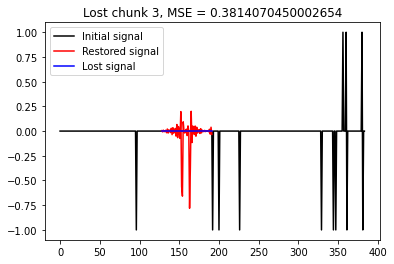

HHHHHHEEEEEEYyYYYY 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


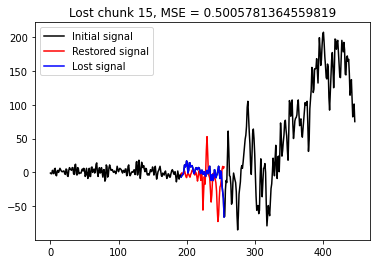

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


HHHHHHEEEEEEYyYYYY 8


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


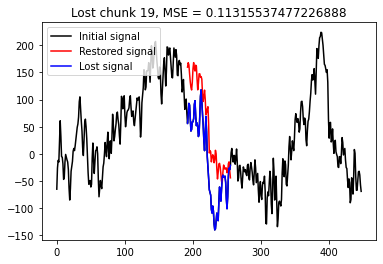

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


HHHHHHEEEEEEYyYYYY 7


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


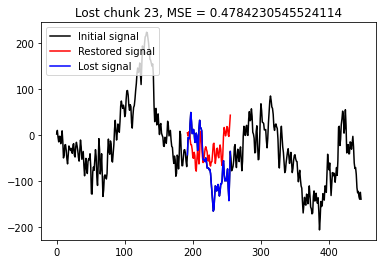

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


HHHHHHEEEEEEYyYYYY 6


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


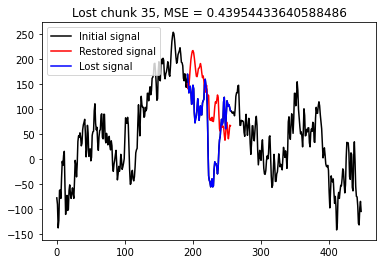

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


HHHHHHEEEEEEYyYYYY 5


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


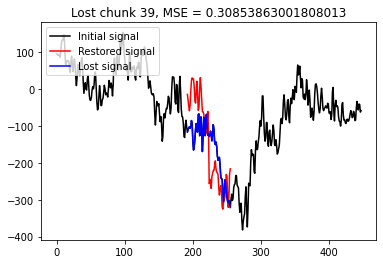

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


HHHHHHEEEEEEYyYYYY 4


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


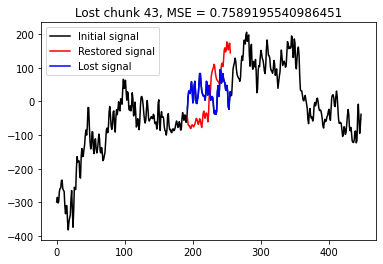

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


HHHHHHEEEEEEYyYYYY 3


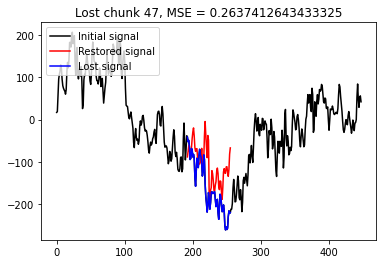

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


HHHHHHEEEEEEYyYYYY 2


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


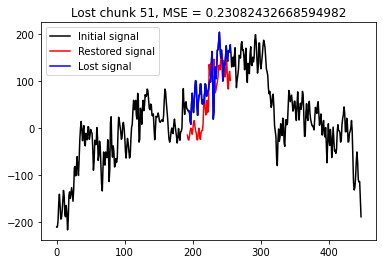

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


HHHHHHEEEEEEYyYYYY 1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


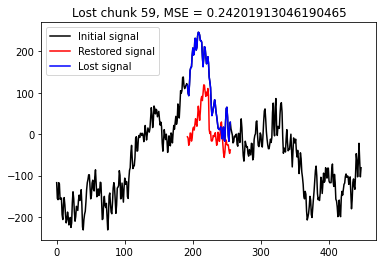

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


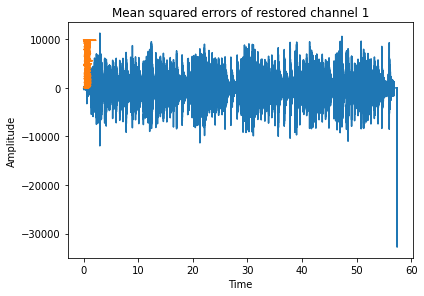

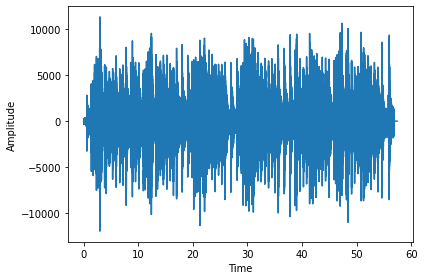

MEAN MSE = 0.613771864558905


In [ ]:
test_visualize("/content/sample_data/ukrainian_anthem_piano.mp3", 32, "trigonometric", 10, 0.25)

In [ ]:
def compare_stffts(reference_audio_path, changed_audio_path):
  audio1, sr1 = librosa.load(reference_audio_path)
  audio2, sr2 = librosa.load(changed_audio_path)
  audio1 = librosa.util.normalize(audio1)
  audio2 = librosa.util.normalize(audio2)
  stfft1 = np.abs(librosa.stft(audio1))
  stfft2 = np.abs(librosa.stft(audio2))
  MSE_array = []
  for i in range(len(stfft1)):
    MSE_array.append(np.square(np.subtract(stfft1[i], stfft2[i]).mean()))
  # MSE = np.square(np.subtract(stfft1, sttft2).mean()
  print(np.array(MSE_array).mean())

[-12.56637061 -12.56134306 -12.55631551 ...  12.55631551  12.56134306
  12.56637061]


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


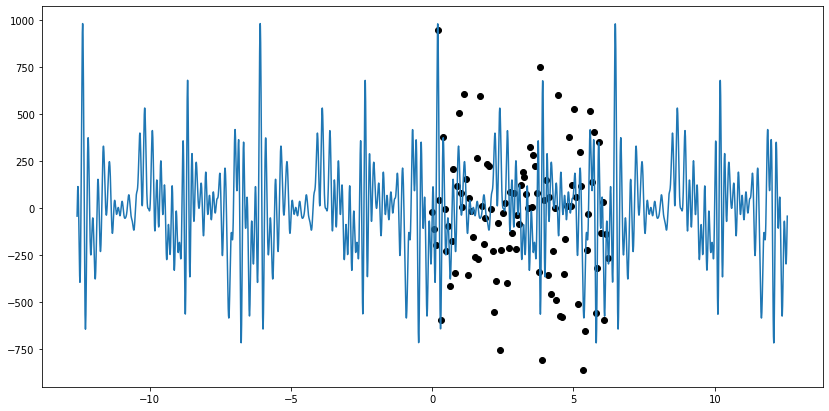

In [ ]:
compare_stffts("/content/sample_data/original.mp3", "/content/sample_data/restored.mp3")
compare_stffts("/content/sample_data/original.mp3", "/content/sample_data/0.10___channel_1___original.mp3")